Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 486kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.81MB/s]



--- Training CNN-1 (Optim: Adam, Epochs: 10) ---
Epoch [1/10], Loss: 0.1263
Epoch [2/10], Loss: 0.0426
Epoch [3/10], Loss: 0.0270
Epoch [4/10], Loss: 0.0201
Epoch [5/10], Loss: 0.0155
Epoch [6/10], Loss: 0.0136
Epoch [7/10], Loss: 0.0111
Epoch [8/10], Loss: 0.0101
Epoch [9/10], Loss: 0.0104
Epoch [10/10], Loss: 0.0064
Final Accuracy for CNN-1: 98.74%

--- Training MLP-1 (Optim: SGD, Epochs: 20) ---
Epoch [1/20], Loss: 0.2018
Epoch [2/20], Loss: 0.0776
Epoch [3/20], Loss: 0.0511
Epoch [4/20], Loss: 0.0373
Epoch [5/20], Loss: 0.0253
Epoch [6/20], Loss: 0.0231
Epoch [7/20], Loss: 0.0186
Epoch [8/20], Loss: 0.0132
Epoch [9/20], Loss: 0.0124
Epoch [10/20], Loss: 0.0101
Epoch [11/20], Loss: 0.0083
Epoch [12/20], Loss: 0.0080
Epoch [13/20], Loss: 0.0064
Epoch [14/20], Loss: 0.0045
Epoch [15/20], Loss: 0.0051
Epoch [16/20], Loss: 0.0039
Epoch [17/20], Loss: 0.0042
Epoch [18/20], Loss: 0.0038
Epoch [19/20], Loss: 0.0029
Epoch [20/20], Loss: 0.0033
Final Accuracy for MLP-1: 98.50%

--- Training

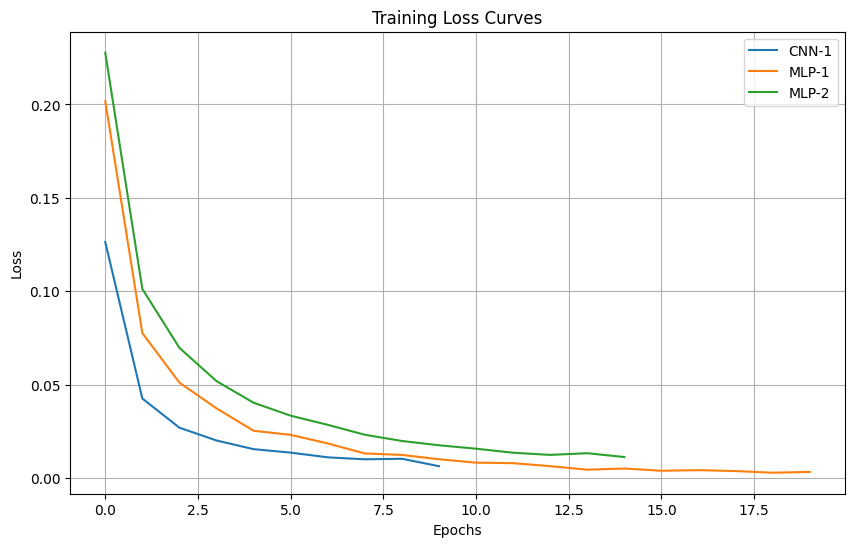


Model      | Optimizer  | Epochs   | Accuracy  
---------------------------------------------
CNN-1      | Adam       | 10       | 98.74%
MLP-1      | SGD        | 20       | 98.50%
MLP-2      | Adam       | 15       | 97.89%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. Configuration & Device Setup
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 64

# Transformations (Normalization is crucial for MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Mean and Std Dev of MNIST
])

# Load MNIST Dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ==========================================
# 2. Define Models (Base Architectures)
# ==========================================

# --- CNN Architecture ---
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Conv2D Layer 1: 32 filters, 3x3 kernel, ReLU
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu1 = nn.ReLU()

        # Conv2D Layer 2: 64 filters, 3x3 kernel, ReLU
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.relu2 = nn.ReLU()

        # Max Pooling: 2x2 kernel
        self.pool = nn.MaxPool2d(kernel_size=2)

        # Dropout: 0.25
        self.dropout = nn.Dropout(0.25)

        # Flattening happens in forward pass
        # Calculate Flatten size:
        # Input: 28x28 -> Conv1(3x3) -> 26x26 -> Conv2(3x3) -> 24x24 -> Pool(2x2) -> 12x12
        # Output channels = 64. So flattened size = 64 * 12 * 12 = 9216

        # Dense Layer: 128 neurons, ReLU
        self.fc1 = nn.Linear(9216, 128)
        self.relu3 = nn.ReLU()

        # Output Layer: 10 neurons
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1) # Flatten
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# --- Flexible MLP Architecture ---
# Designed to handle "512-256-128" and "256" configurations dynamically
class MLP(nn.Module):
    def __init__(self, hidden_layers=[256, 128]):
        super(MLP, self).__init__()
        layers = []
        input_dim = 784 # 28*28 flattened

        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim)) # BatchNormalization
            layers.append(nn.ReLU())                  # Activation
            input_dim = hidden_dim # Set input for next layer

        layers.append(nn.Linear(input_dim, 10)) # Output Layer

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1) # Flatten input (Batch, 28, 28) -> (Batch, 784)
        x = self.network(x)
        return x

# ==========================================
# 3. Training Engine
# ==========================================
def train_and_evaluate(model, optimizer_name, epochs, model_name):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # Select Optimizer based on task
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Added momentum for stability

    loss_history = []

    print(f"\n--- Training {model_name} (Optim: {optimizer_name}, Epochs: {epochs}) ---")

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    # Final Evaluation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Final Accuracy for {model_name}: {accuracy:.2f}%")

    return loss_history, accuracy

# ==========================================
# 4. Running the Experiments (From the Table)
# ==========================================

# Dictionary to store results for visualization
results = {}

# --- Experiment 1: CNN-1 ---
# Config: FC layer 128 (default in class), Optimizer Adam, 10 Epochs
cnn_model = CNN()
loss_cnn, acc_cnn = train_and_evaluate(cnn_model, "Adam", 10, "CNN-1")
results["CNN-1"] = loss_cnn

# --- Experiment 2: MLP-1 ---
# Config: FC layers 512-256-128, Optimizer SGD, 20 Epochs
mlp1_model = MLP(hidden_layers=[512, 256, 128])
loss_mlp1, acc_mlp1 = train_and_evaluate(mlp1_model, "SGD", 20, "MLP-1")
results["MLP-1"] = loss_mlp1

# --- Experiment 3: MLP-2 ---
# Config: FC layer 256, Optimizer Adam, 15 Epochs
mlp2_model = MLP(hidden_layers=[256])
loss_mlp2, acc_mlp2 = train_and_evaluate(mlp2_model, "Adam", 15, "MLP-2")
results["MLP-2"] = loss_mlp2

# ==========================================
# 5. Visualization & Results Table
# ==========================================

# Plot Loss Curves
plt.figure(figsize=(10, 6))
for name, losses in results.items():
    plt.plot(losses, label=name)

plt.title("Training Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Print Final Comparison Table
print("\n" + "="*40)
print(f"{'Model':<10} | {'Optimizer':<10} | {'Epochs':<8} | {'Accuracy':<10}")
print("-" * 45)
print(f"{'CNN-1':<10} | {'Adam':<10} | {10:<8} | {acc_cnn:.2f}%")
print(f"{'MLP-1':<10} | {'SGD':<10} | {20:<8} | {acc_mlp1:.2f}%")
print(f"{'MLP-2':<10} | {'Adam':<10} | {15:<8} | {acc_mlp2:.2f}%")
print("="*40)